# Experiments in reproducing the LSTM architecture for robot control using Torch.

In [1]:
import sys
sys.path.append("..")
from settings import Config

import pathlib

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

## Generate training data for some kind of sequence orig_data

I am going to go with the assumption that the width of the input orig_data is the latent stuff. 

```
[x_1,...x_128]
x_2 sin(i* pi/10)  
x_3 cos(i* pi/10)
x_4 sin(i* pi/20)
x_5 cos(i* pi/20)
x_6 is 0, 1, -1 at specific points
the rest is noise

y_1 sin(i-10)/10
y_2 sum of x_2
y_3 sum of x_5
y_4 1 or -1 depending on whether the previous non-zero x_6 was 1 or -1
```

In [49]:
# Generate training orig_dat_orig for the LSTM using np
# total_length = 10000
# latent_size = Config()["robot"]["latent_encoding_size"]
total_length = 100
latent_size = 6

dat_orig = torch.rand(latent_size, total_length)
# x_2 sin(i* pi/10)  
dat_orig[2] = torch.linspace(0, 2 * torch.pi * total_length / 10.0, steps = total_length)
dat_orig[2].sin_()

# x_3 cos(i* pi/10)
dat_orig[3] = torch.linspace(0, 2 * torch.pi * total_length / 10.0, steps = total_length)
dat_orig[3].cos_()

# x_4 sin(i* pi/20)
dat_orig[4] = torch.linspace(0, 2 * torch.pi * total_length / 20.0, steps = total_length)
dat_orig[4].sin_()

# x_5 cos(i* pi/20)
dat_orig[5] = torch.linspace(0, 2 * torch.pi * total_length / 20.0, steps = total_length)
dat_orig[5].cos_()

print(dat_orig)
print(dat_orig.shape)

tensor([[ 9.3235e-01,  7.4008e-01,  9.6988e-01,  3.2059e-01,  7.0504e-01,
          8.5203e-01,  3.0817e-01,  6.9421e-02,  8.1475e-01,  1.1740e-01,
          3.7879e-01,  2.8010e-01,  8.3906e-01,  9.1588e-01,  7.4571e-01,
          4.1402e-01,  5.3760e-01,  1.0889e-01,  4.2265e-01,  8.7244e-01,
          8.6526e-01,  5.4520e-01,  7.7631e-01,  4.7233e-01,  5.6860e-01,
          9.9498e-03,  6.9939e-01,  4.3072e-02,  2.3406e-01,  4.3545e-01,
          9.2297e-02,  4.4073e-01,  5.1962e-01,  8.1517e-01,  6.5379e-02,
          1.0118e-01,  3.1984e-02,  8.3796e-01,  4.3169e-01,  6.1159e-01,
          1.1581e-01,  1.4442e-01,  4.9445e-01,  5.9801e-01,  9.1395e-01,
          1.4569e-01,  8.6240e-01,  1.0553e-01,  4.4005e-01,  3.3570e-01,
          5.3075e-01,  4.3463e-01,  3.2352e-01,  7.6608e-01,  3.1378e-02,
          7.0431e-01,  9.9695e-01,  7.0923e-01,  3.0460e-01,  7.4866e-02,
          5.6592e-01,  1.1034e-01,  2.2639e-01,  4.7553e-01,  9.0788e-01,
          7.5204e-01,  2.7925e-01,  9.

In [50]:
#dat_orig[0].shape
# dat_orig[0] = 


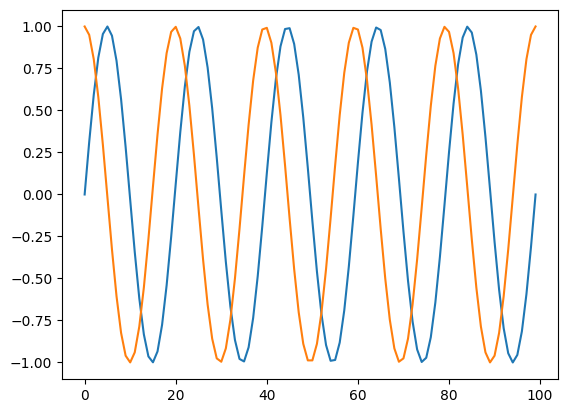

In [51]:
# Visualize the training dat_orig
# plt.plot(dat_orig[2].numpy()[0:100])
# plt.plot(dat_orig[3].numpy()[0:100])
plt.plot(dat_orig[4].numpy()[0:100])
plt.plot(dat_orig[5].numpy()[0:100])

In [52]:
# Model Parameters
# latent_size = 16  # Dimension of each vector in the sequence
hidden_size = 32  # Size of hidden state in LSTM
num_layers = 2    # Number of LSTM layers
sequence_length = 10  # Number of vectors in input sequence

In [53]:
# This creates the training data from the single long sequence

# I guess I need to transpose the tensor
dat_origg = dat_orig
#dat_orig.transpose_(0, 1)
dat_orig = dat_orig.transpose(0,1)

# Prepare training data
inputs = []
targets = []
for i in range(total_length - sequence_length):
    # Input is a subsequence of length `sequence_length`
    input_seq = dat_orig[i:i + sequence_length]  # Shape: [sequence_length, latent_size]
    
    # Target is the next vector after the input sequence
    target = dat_orig[i + sequence_length]       # Shape: [latent_size]
    
    # Append to lists
    inputs.append(input_seq)
    targets.append(target)

# Convert lists to tensors for training
inputs = torch.stack(inputs)   # Shape: [num_samples, sequence_length, latent_size]
targets = torch.stack(targets) # Shape: [num_samples, latent_size]

# Verify shapes
print("Inputs shape:", inputs.shape)   # Expected: [num_samples, sequence_length, latent_size]
print("Targets shape:", targets.shape) # Expected: [num_samples, latent_size]

Inputs shape: torch.Size([90, 10, 6])
Targets shape: torch.Size([90, 6])


In [7]:
# This is the architecture created by chatgpt



class LSTMSequencePredictor(nn.Module):
    def __init__(self, latent_size, hidden_size, num_layers):
        super(LSTMSequencePredictor, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_size]
        out, _ = self.lstm(x)  # LSTM output shape: [batch_size, sequence_length, hidden_size]
        out = self.fc(out[:, -1, :])  # Take last time step output and pass through the fully connected layer
        return out  # Predicted next vector

# Instantiate model, loss function, and optimizer
model = LSTMSequencePredictor(latent_size=latent_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:

# Dummy Data (Replace with actual data)
# Suppose `data` is a tensor of shape [num_sequences, sequence_length + 1, latent_size]
# where each sequence of `sequence_length` vectors is followed by the next vector to predict.
#num_sequences = 100  # Example number of sequences
#data = torch.randn(num_sequences, sequence_length + 1, latent_size)


In [9]:

# Training Loop
num_epochs = 100
num_sequences = inputs.shape[0]
print(num_sequences)

90


In [10]:

for epoch in range(num_epochs):
    model.train()
    
    # Loop over each sequence in the batch
    for i in range(num_sequences):
        # Prepare input and target
        #input_seq = data[i, :sequence_length, :]  # Input sequence
        #target = data[i, sequence_length, :]      # Target is the 
        # next vector
        
        input_seq = inputs[i]
        target = targets[i]

        # Reshape for batch compatibility
        input_seq = input_seq.unsqueeze(0)  # Shape: [1, sequence_length, latent_size]
        target = target.unsqueeze(0)        # Shape: [1, latent_size]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0: # was 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [2/100], Loss: 0.2075
Epoch [4/100], Loss: 0.0175
Epoch [6/100], Loss: 0.0290
Epoch [8/100], Loss: 0.0128
Epoch [10/100], Loss: 0.0117
Epoch [12/100], Loss: 0.0126
Epoch [14/100], Loss: 0.0330
Epoch [16/100], Loss: 0.0096
Epoch [18/100], Loss: 0.0228
Epoch [20/100], Loss: 0.0101
Epoch [22/100], Loss: 0.0102
Epoch [24/100], Loss: 0.0165
Epoch [26/100], Loss: 0.0230
Epoch [28/100], Loss: 0.0081
Epoch [30/100], Loss: 0.0208
Epoch [32/100], Loss: 0.0093
Epoch [34/100], Loss: 0.0111
Epoch [36/100], Loss: 0.0170
Epoch [38/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0079
Epoch [42/100], Loss: 0.0099
Epoch [44/100], Loss: 0.0084
Epoch [46/100], Loss: 0.0081
Epoch [48/100], Loss: 0.0083
Epoch [50/100], Loss: 0.0081
Epoch [52/100], Loss: 0.0251
Epoch [54/100], Loss: 0.0331
Epoch [56/100], Loss: 0.0077
Epoch [58/100], Loss: 0.0081
Epoch [60/100], Loss: 0.0157
Epoch [62/100], Loss: 0.0132
Epoch [64/100], Loss: 0.0152
Epoch [66/100], Loss: 0.0072
Epoch [68/100], Loss: 0.0114
Epoch [70/100], Lo

In [ ]:
start = 0

result = []
model.eval()
with torch.no_grad():
    for i in range(0, total_length - sequence_length):
        input_seq = dat_orig[start+i : start+ i + sequence_length]
        # print(input_seq.shape)    
        input_val = input_seq.unsqueeze(0)
        #print(input_val)
        #print(input_val.shape)
        val = model(input_val)
        result.append(val.squeeze(0).tolist())
print(result)

torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])


[-0.04765297 -0.31553859 -0.62141991 -0.8424387  -0.97004116 -1.01473808
 -0.92097837 -0.74575073 -0.47532076 -0.18418625  0.13057134  0.39694783
  0.61122292  0.79853678  0.96376836  0.99668455  0.92316145  0.77539951
  0.48671046  0.25523525 -0.11827031 -0.41109857 -0.68296301 -0.8843317
 -1.00175428 -1.02775729 -0.9054594  -0.68033105 -0.39853382 -0.10156895
  0.2131447   0.47990134  0.70836085  0.87869292  0.92488402  0.96507072
  0.85933346  0.70915371  0.44948068  0.21422791 -0.13479033 -0.43562961
 -0.7037977  -0.90183347 -0.98770744 -0.9632324  -0.82754594 -0.7012589
 -0.3617636  -0.08578152  0.21246693  0.49268082  0.62950486  0.83207786
  0.88000107  0.95412773  0.82698691  0.69831407  0.41106763  0.1411943
 -0.17102666 -0.50242686 -0.75257301 -0.92504311 -0.99732417 -0.96671039
 -0.80441666 -0.5871262  -0.30628204  0.0036029   0.27211848  0.56441623
  0.76112801  0.94848692  0.9663856   0.97297782  0.81208557  0.68591976
  0.35783339  0.02345963 -0.25604001 -0.58894593 -0.81

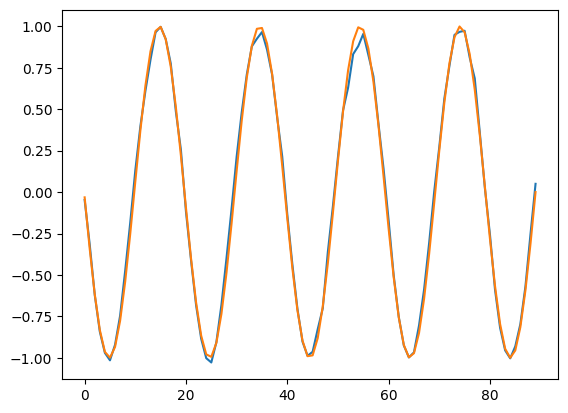

In [57]:
res = np.array(result)
print(res[:,4])
plt.plot(res[:,4])
plt.plot(dat_origg[4].numpy()[10:100])
#plt.plot(dat_origg[5].numpy()[0:100])


In [ ]:
#